# Convolutional Deep Belief Network

## Import



In [ ]:
def get_cdbn_library():
  files = ["CDBN.py", "CRBM.py", "DATA_HANDLER.py"]
  repository_url = "https://raw.githubusercontent.com/SimoDR/Convolutional_Deep_Belief_Network/emnist/src/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_cdbn_library()

import CRBM as crbm
import CDBN as cdbn
import DATA_HANDLER as data_handler

In [2]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import to_categorical
tf.disable_eager_execution()
# tf.disable_v2_behavior()
import random
import numpy as np
import math
import matplotlib.pyplot as plt

## Data

I load the EMNIST dataset and perform some preprocessing

In [3]:
!pip install extra-keras-datasets

from extra_keras_datasets import emnist
(train_images, train_labels_normal),(test_images, test_labels_normal) = emnist.load_data(type='balanced') # balanced version of EMNIST

# one hot encoding
train_labels = to_categorical(train_labels_normal,47)
test_labels = to_categorical(test_labels_normal,47)

# scale the pixels values in [0,1]
train_images = train_images/255
test_images = test_images/255


INFO:root:Loading dataset = emnist


### Semi-supervised learning

I train the CDBN on the whole mnist dataset but without labels: only for the last softmax layers I use a subset of the dataset with labels.

In [4]:
unsupervised_training_images = train_images
sampler = random.sample(range(train_images.shape[0]), train_images.shape[0]) # In this case I sample the whole training set, it's not semi-supervised

supervised_training_images = train_images[sampler]
supervised_training_labels = train_labels[sampler]

I use the data handler to import data in the model

In [5]:
emnist_dataset = data_handler.DATA_HANDLER(unsupervised_training_images, 
                                          supervised_training_images, 
                                          supervised_training_labels, 
                                          test_images, 
                                          test_labels)


## Model



### Model building

In [72]:
tf.reset_default_graph()
sess = tf.Session()

my_cdbn = cdbn.CDBN(name = 'emnist_cdbn', 
                    batch_size = 200, 
                    path = '/home/', 
                    data = emnist_dataset, 
                    session = sess, 
                    verbosity = 2)

my_cdbn.add_layer('layer_1', fully_connected = False, v_height = 28, v_width = 28, v_channels = 1, f_height = 7, f_width = 7, f_number = 30, 
               init_biases_H = -3, init_biases_V = 0.01, init_weight_stddev = 0.01, 
               gaussian_unit = True, gaussian_variance = 0.2, 
               prob_maxpooling = True, padding = True, 
               learning_rate = 0.0001, learning_rate_decay = 0.6, momentum = 0.5, decay_step = 50000,  
               weight_decay = 1.0, sparsity_target = 0.003, sparsity_coef = 0.1)

my_cdbn.add_layer('layer_2', fully_connected = False, v_height = "auto", v_width = "auto", v_channels = "auto", f_height = 11, f_width = 11, f_number = 60, 
               init_biases_H = -3, init_biases_V = 0.025, init_weight_stddev = 0.025, 
               gaussian_unit = False, gaussian_variance = 0.2, 
               prob_maxpooling = True, padding = True, 
               learning_rate = 0.005, learning_rate_decay = 0.8, momentum = 0.9, decay_step = 50000,  
               weight_decay = 0.1, sparsity_target = 0.1, sparsity_coef = 0.1)



my_cdbn.add_softmax_layer(47, 0.1)

my_cdbn.lock_cdbn()

tf.get_variable_scope().reuse_variables()


--------------------------
Successfully adding convolutional layer layer_1 to CDBN emnist_cdbn with configuration of:
Visible: (28,28,1)
Filters: (7,7,30) with padding ON (SAME)
Hidden:  (28,28,30)
Probabilistic max pooling ON with stride = 2: 
Gaussian unit ON
--------------------------
Successfully adding convolutional layer layer_2 to CDBN emnist_cdbn with configuration of:
Visible: (14,14,30)
Filters: (11,11,60) with padding ON (SAME)
Hidden:  (14,14,60)
Probabilistic max pooling ON with stride = 2: 
--------------------------
Successfully added softmax layer to the CDBN emnist_cdbn
--------------------------
Successfully locked the CDBN emnist_cdbn


## Training

In [73]:
# tf.debugging.enable_check_numerics() # to debug nan's

my_cdbn.manage_layers(['layer_1','layer_2'],[],[1200,10000], [2,2], 20000, restore_softmax = False, fine_tune = True)

--------------------------
Successfully initialized the layer layer_1 of CDBN emnist_cdbn
--------------------------
Successfully initialized the layer layer_2 of CDBN emnist_cdbn
--------------------------
Successfully initialized the softmax layer of CDBN emnist_cdbn
--------------------------
Starting training the layer layer_1 of CDBN emnist_cdbn
--------------------------
Step 100: reconstruction error = 19487.41103 (0.045 sec), err = 15744.12207, con = 20662.41797 and weight upgrade to weight ratio is 27309.40 percent  -----  Estimated remaining time is 54 sec
Step 200: reconstruction error = 19022.95048 (0.043 sec), err = 15933.23047, con = 27893.36914 and weight upgrade to weight ratio is 27426.15 percent  -----  Estimated remaining time is 47 sec
Step 300: reconstruction error = 17444.96588 (0.044 sec), err = 12797.15625, con = 24748.86719 and weight upgrade to weight ratio is 27420.71 percent  -----  Estimated remaining time is 41 sec
Step 400: reconstruction error = 16009.38

## Evaluation

I get about 89% accuracy on the training set, and 85.5% on the test set in a 10 minutes training. I was not able to improve it more than this.

In [74]:
my_cdbn.do_eval()

--------------------------
Successfully evaluated the CDBN on the softmax_train set: 
 100598 examples are correctly classified out of 112800 total examples
 Precision is 89.18 percent
--------------------------
Successfully evaluated the CDBN on the test set: 
 16093 examples are correctly classified out of 18800 total examples
 Precision is 85.60 percent


## Visualizing

### Filters
For each layer, I plot the learned filters. For the deeper layers, the visualization consists in multiple channels.

In [75]:
def _plot_layer_filters(weights):
  num_subplots = np.shape(weights)[3]
  num_channels = np.shape(weights)[2]
  n_cols = 8
  n_rows = num_subplots // 8 + 1 
  
  for k in range(num_channels):
    print("\n-- Channel: ",k+1,"--")
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(12, 12))
    for i in range(n_cols*n_rows):
      col = i % n_cols
      row = i // n_cols
      if i >= num_subplots:
        axes[row, col].imshow(np.zeros((weights.shape[0],weights.shape[0])), cmap=plt.cm.gray) # I fill the possibly not full last row with black squares
      else:
        axes[row, col].imshow(weights[:, :, k, i], cmap=plt.cm.gray)  # here we select the weights we want to plot
    plt.show()

def plot_filters(number_of_layers):
  for i in range(number_of_layers):
    kernels = my_cdbn.layer_name_to_object[my_cdbn.layer_level_to_name[i]].kernels
    W = kernels.eval(session=sess)
    # W = _apply_threshold(W, .1)
    print("----------------------------")
    print("Plotting filters of layer ",i+1)
    _plot_layer_filters(W)
    print("----------------------------")

----------------------------
Plotting filters of layer  1

-- Channel:  1 --


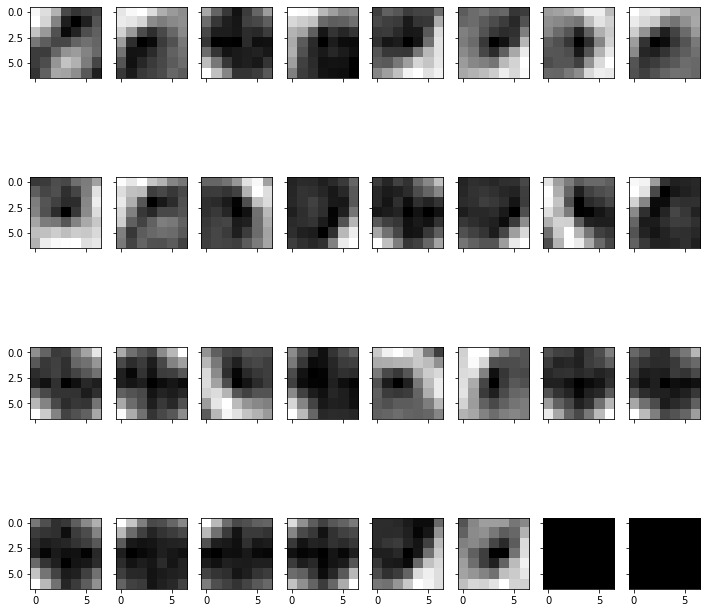

----------------------------
----------------------------
Plotting filters of layer  2

-- Channel:  1 --


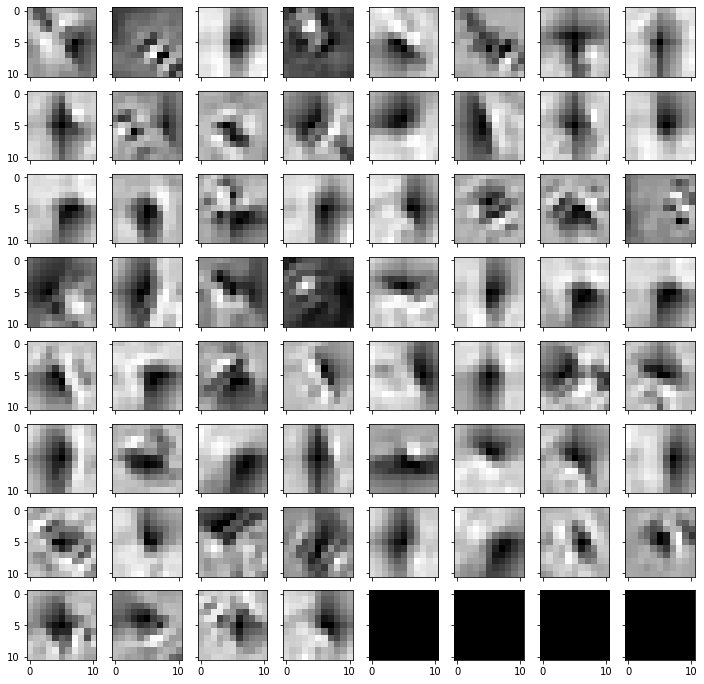


-- Channel:  2 --


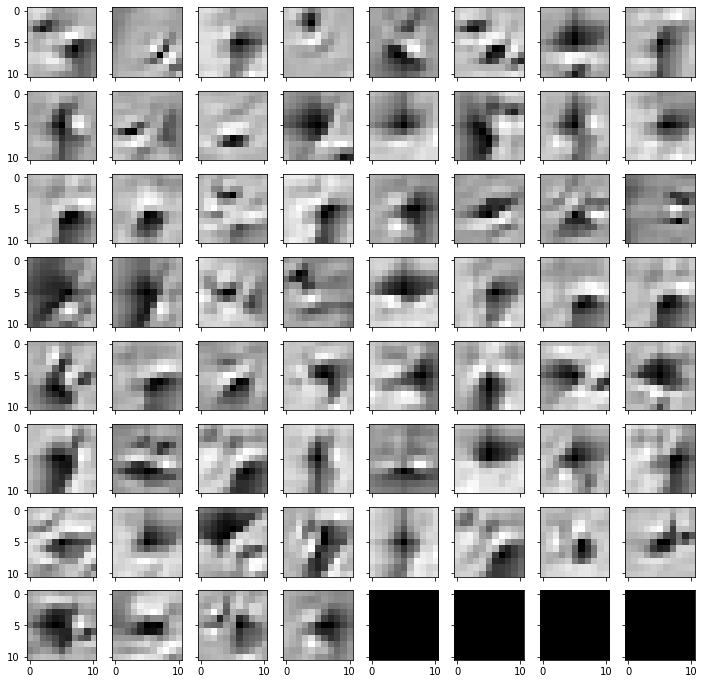


-- Channel:  3 --


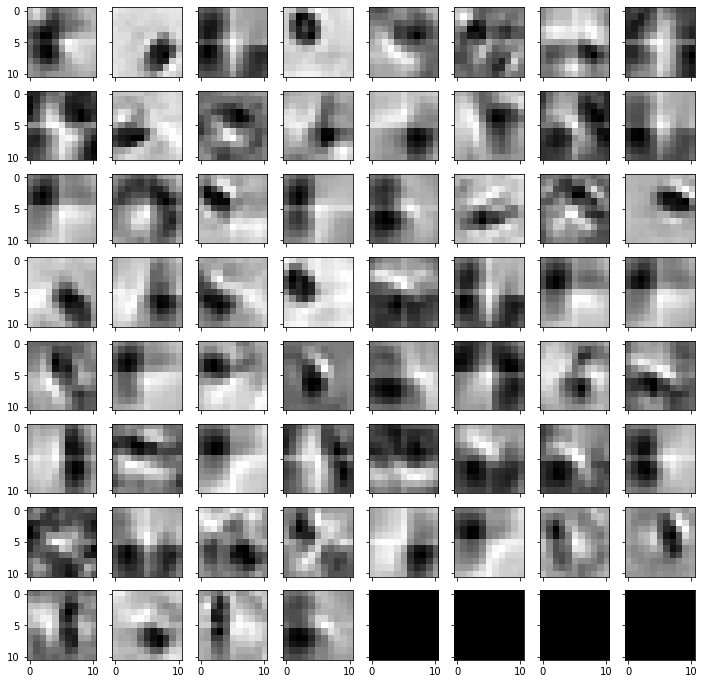


-- Channel:  4 --


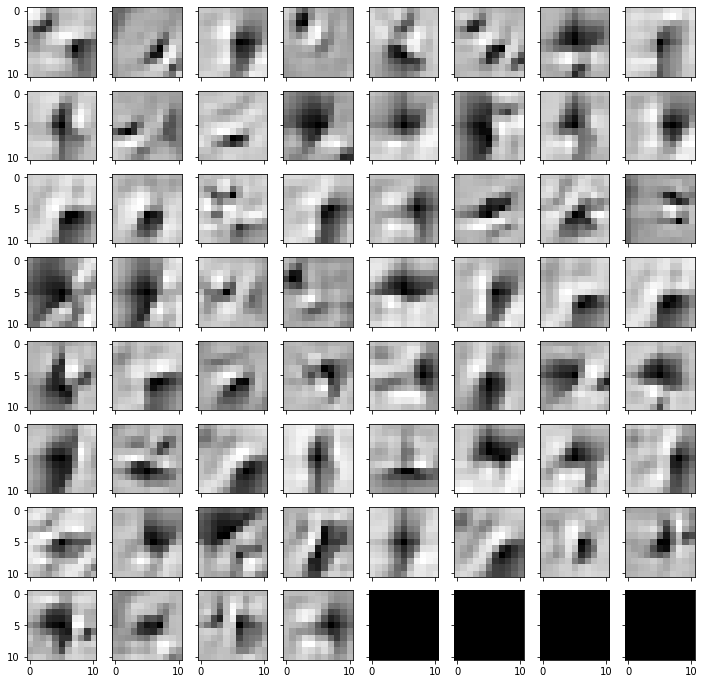


-- Channel:  5 --


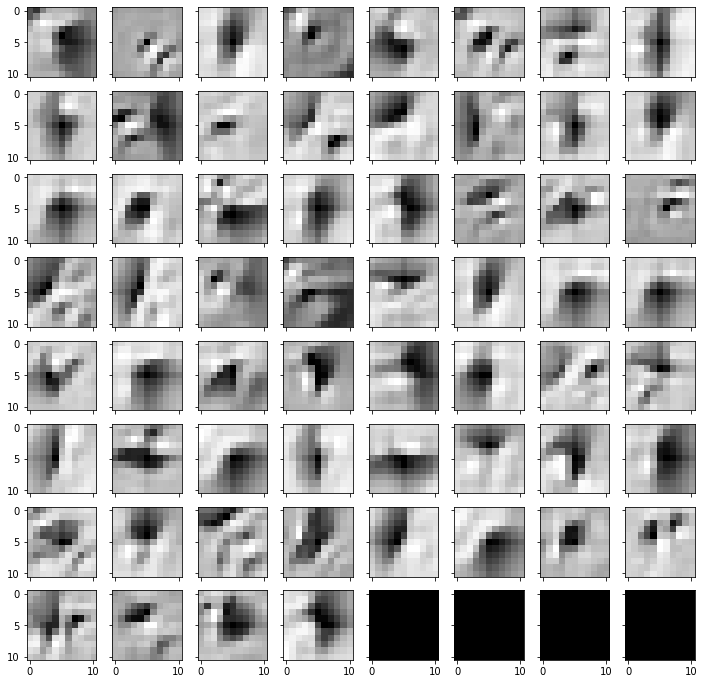


-- Channel:  6 --


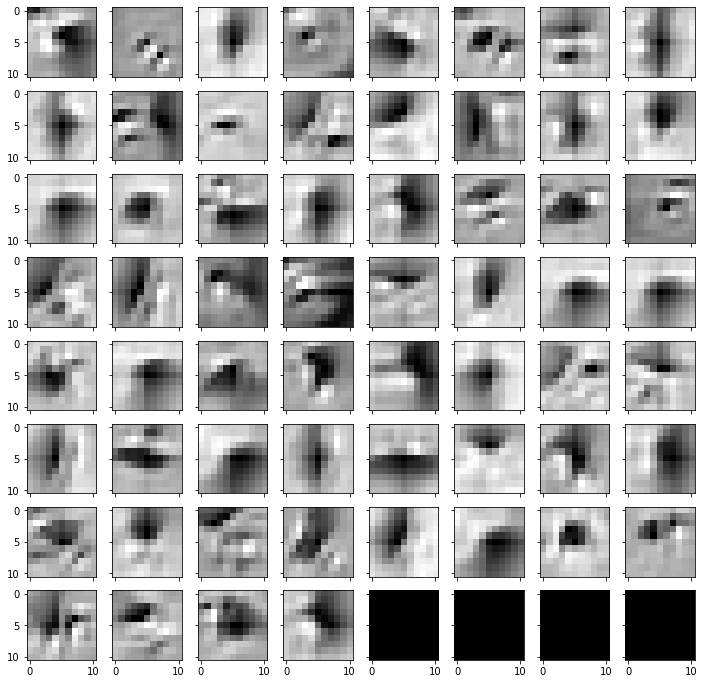


-- Channel:  7 --


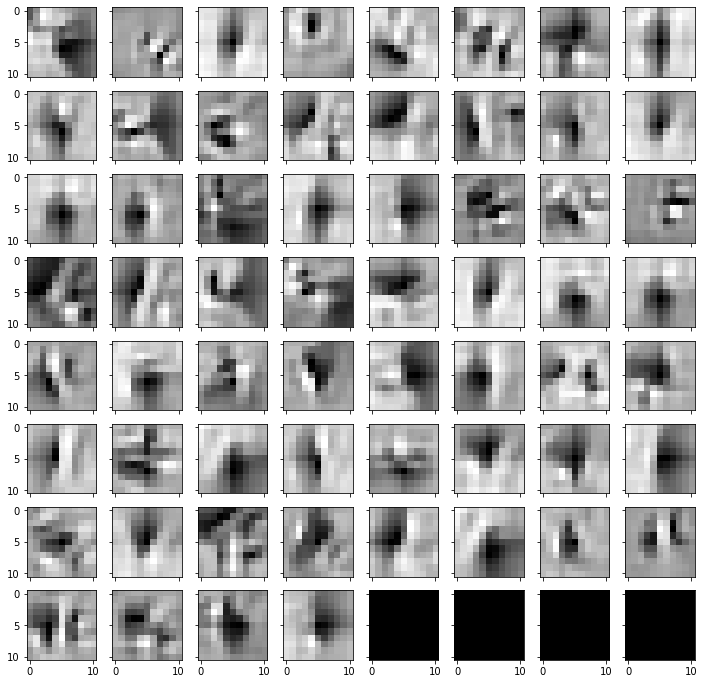


-- Channel:  8 --


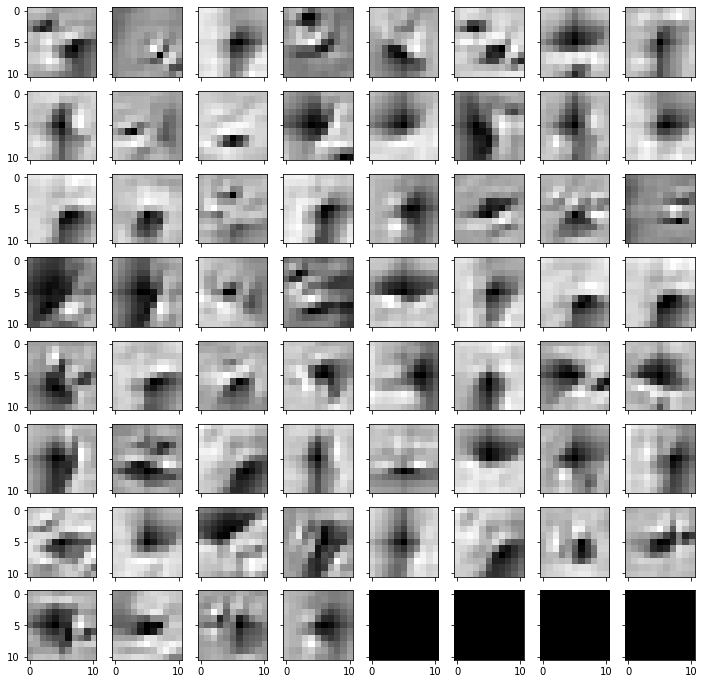


-- Channel:  9 --


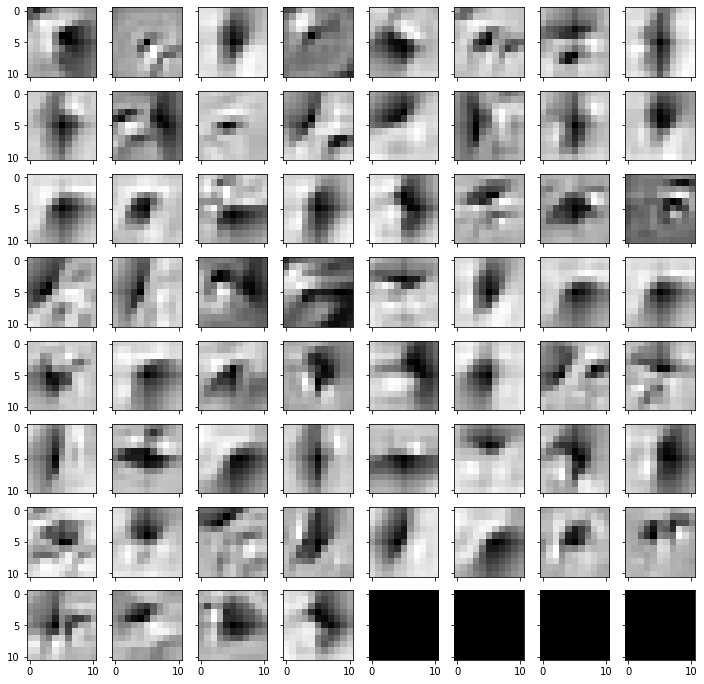


-- Channel:  10 --


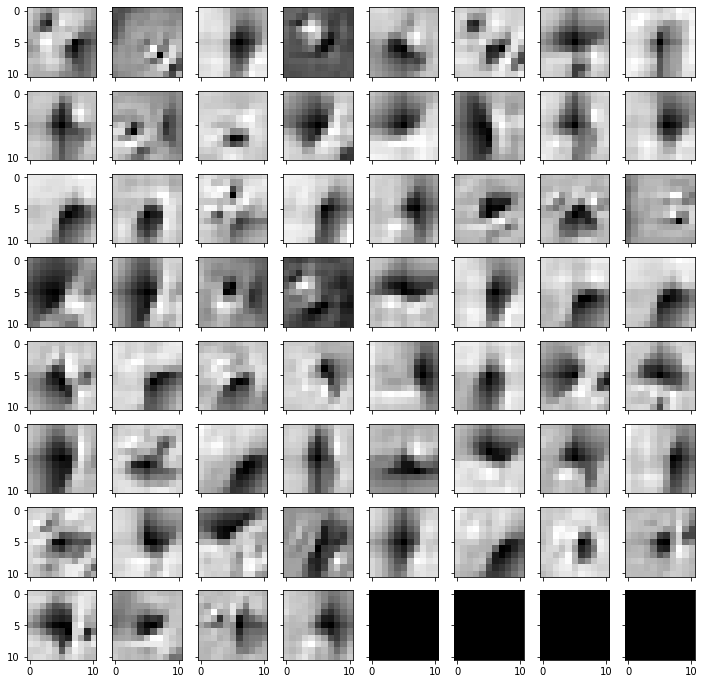


-- Channel:  11 --


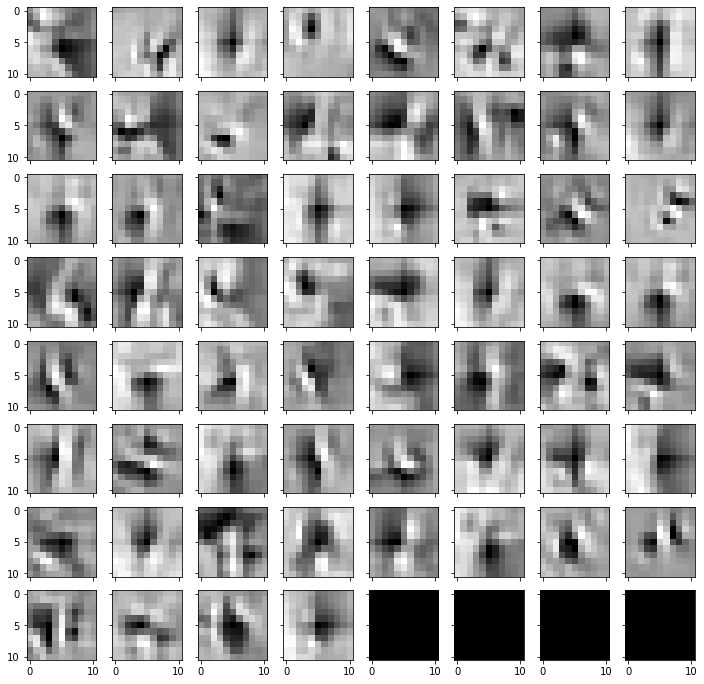


-- Channel:  12 --


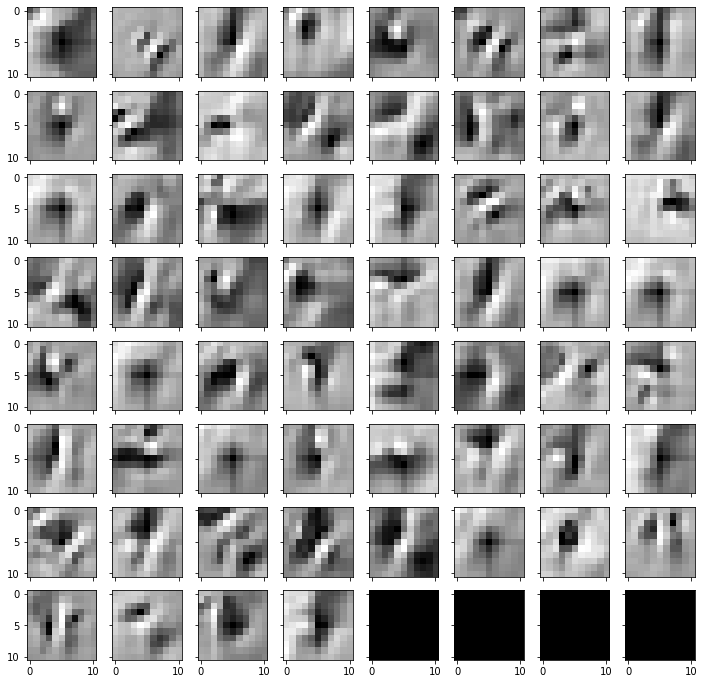


-- Channel:  13 --


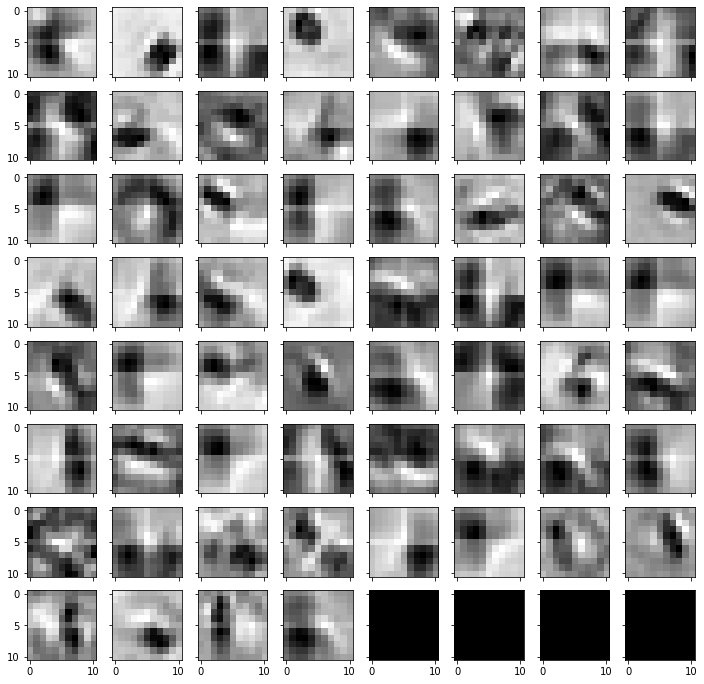


-- Channel:  14 --


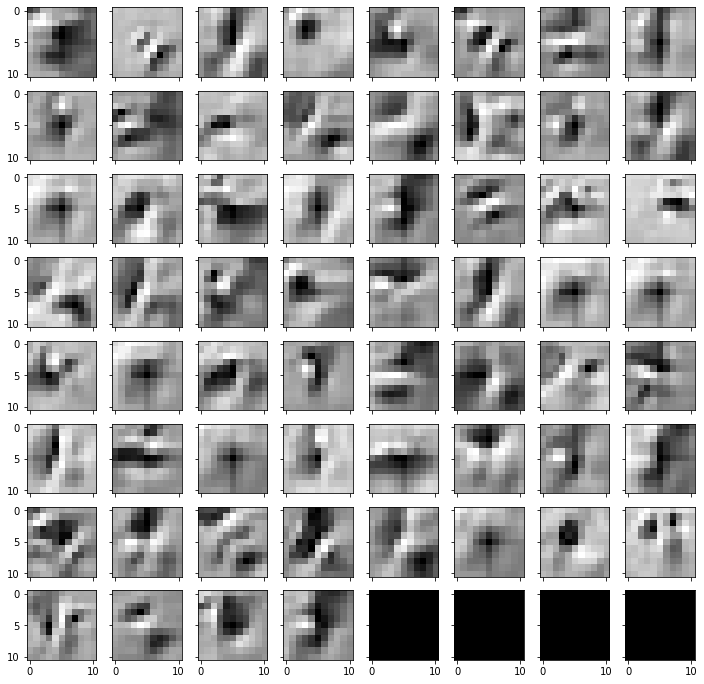


-- Channel:  15 --


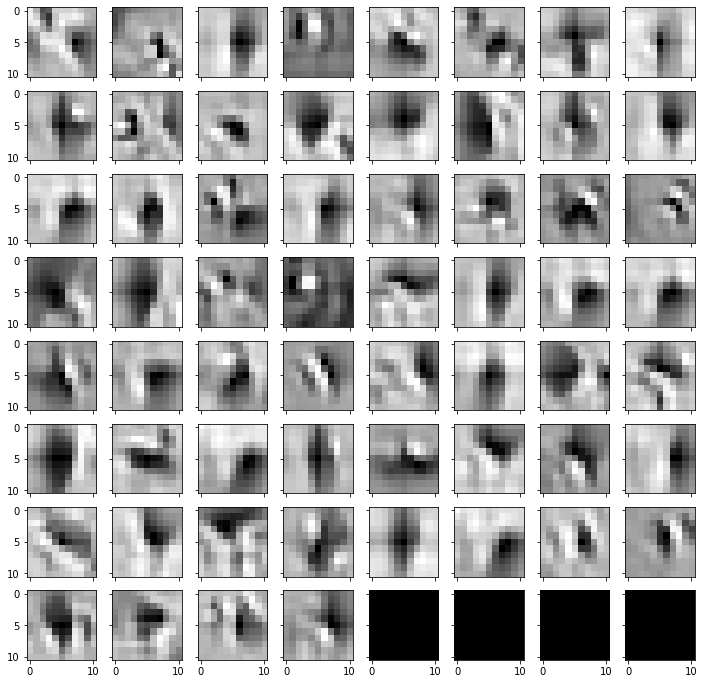


-- Channel:  16 --


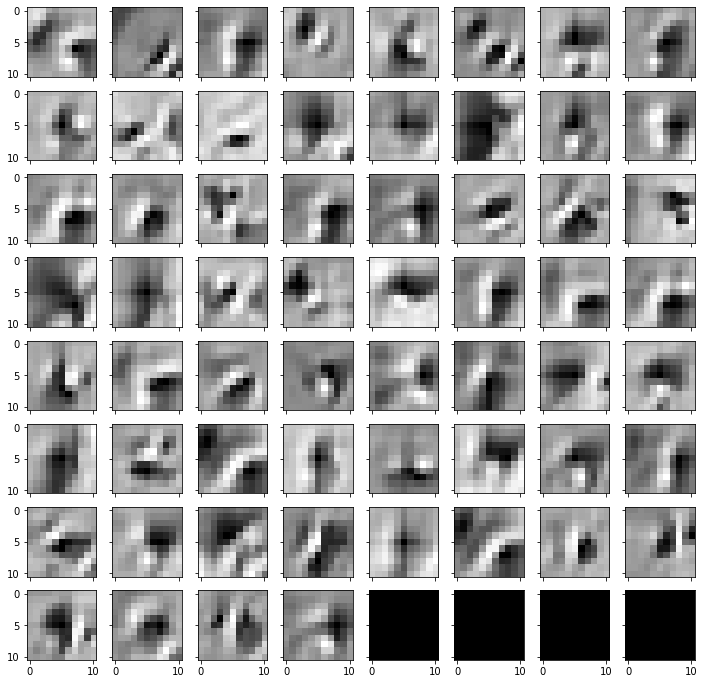


-- Channel:  17 --


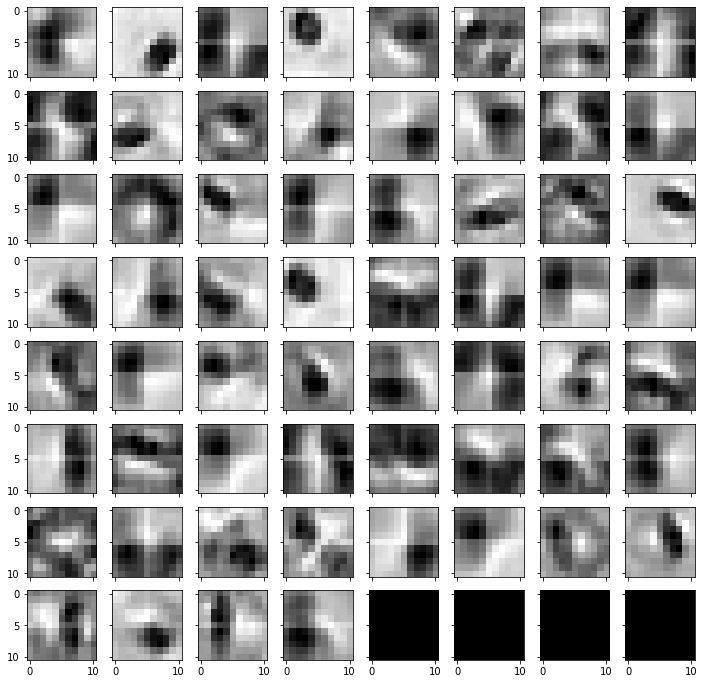


-- Channel:  18 --


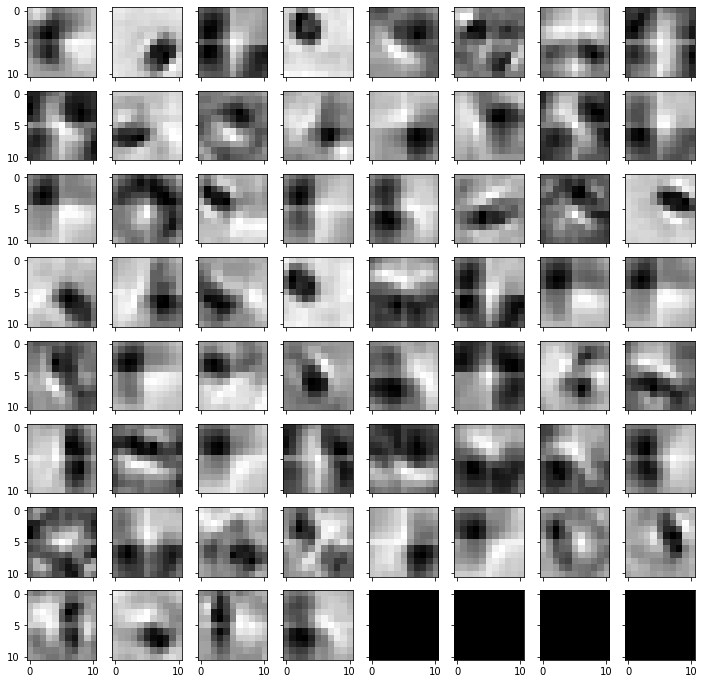


-- Channel:  19 --


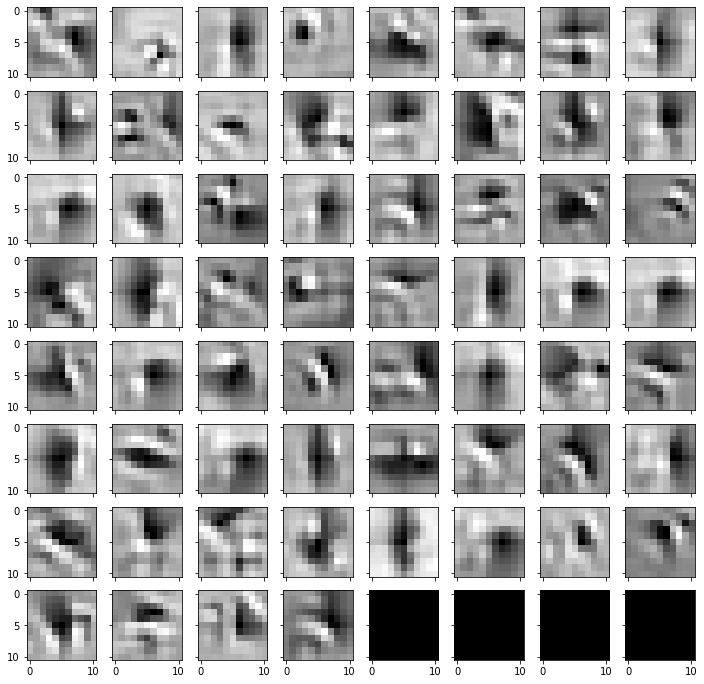


-- Channel:  20 --


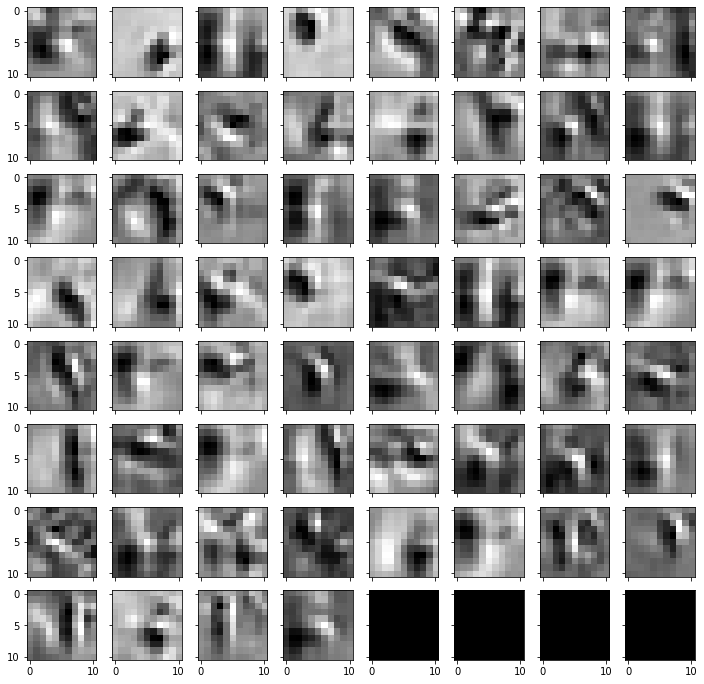


-- Channel:  21 --


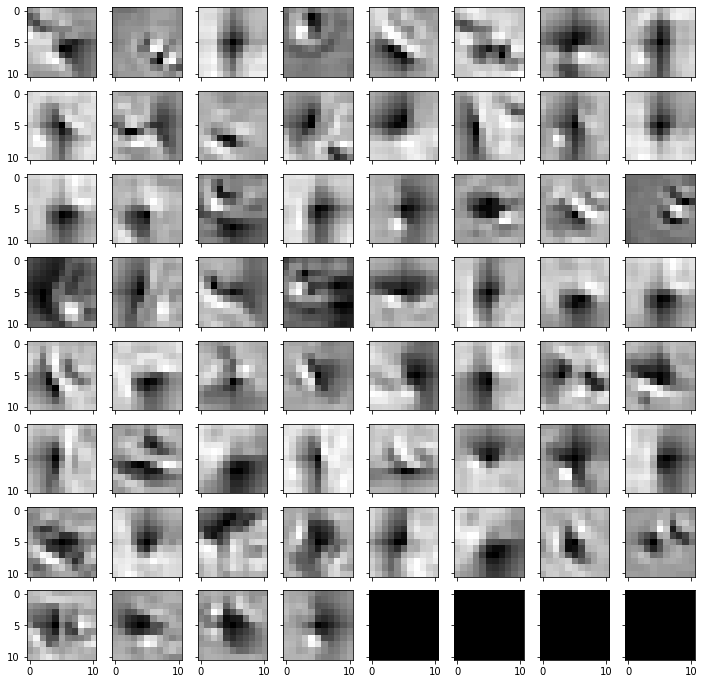


-- Channel:  22 --


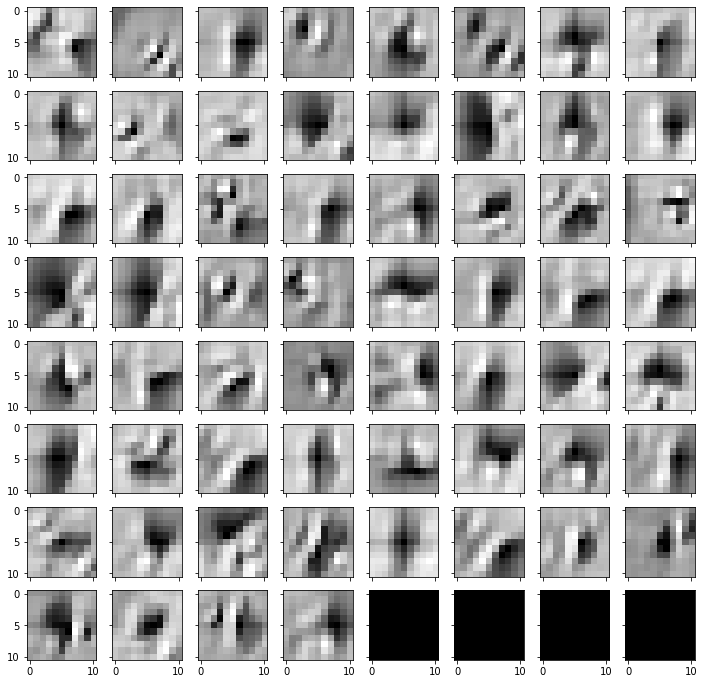


-- Channel:  23 --


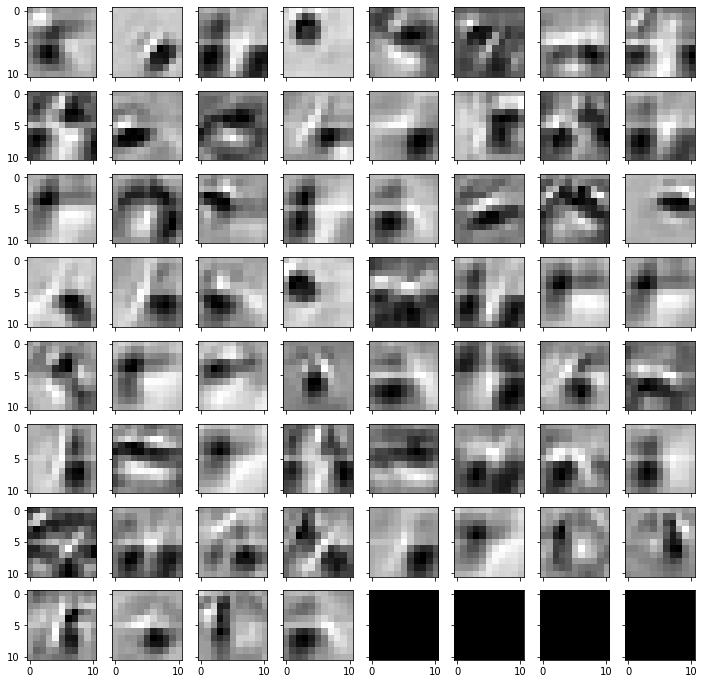


-- Channel:  24 --


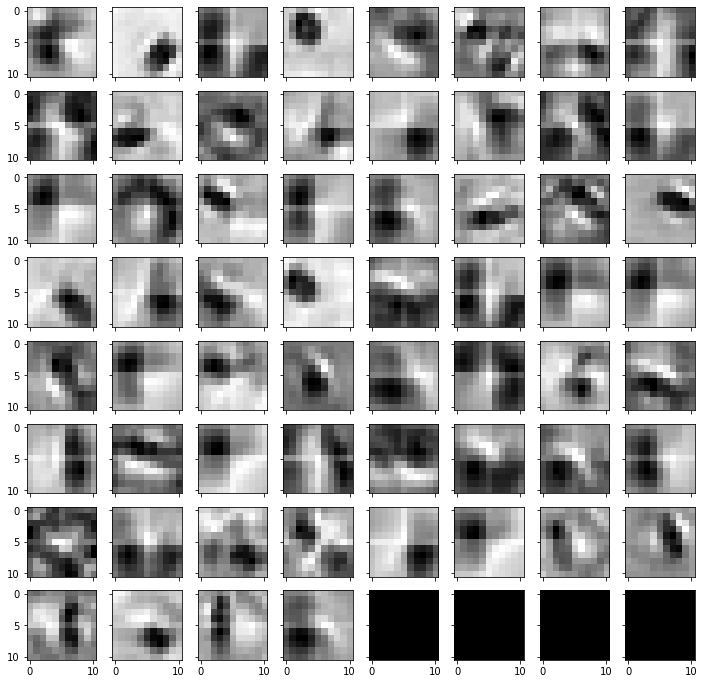


-- Channel:  25 --


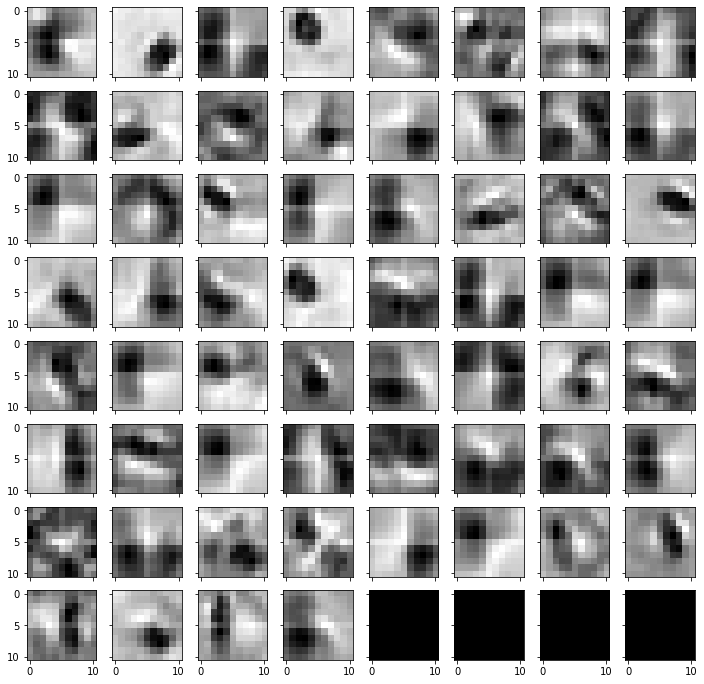


-- Channel:  26 --


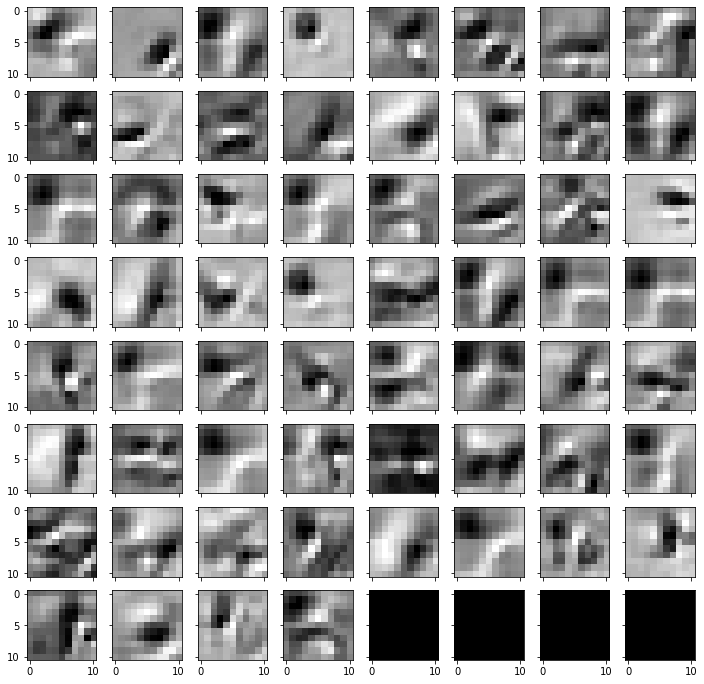


-- Channel:  27 --


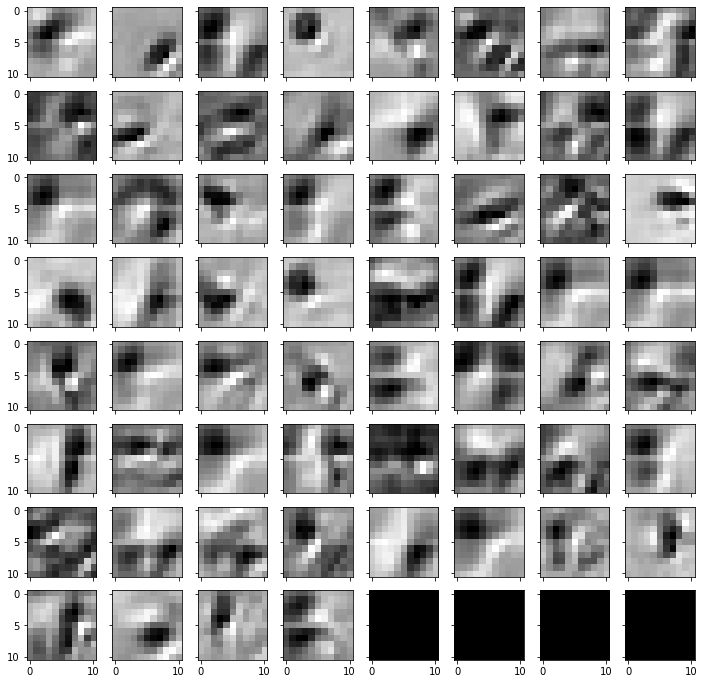


-- Channel:  28 --


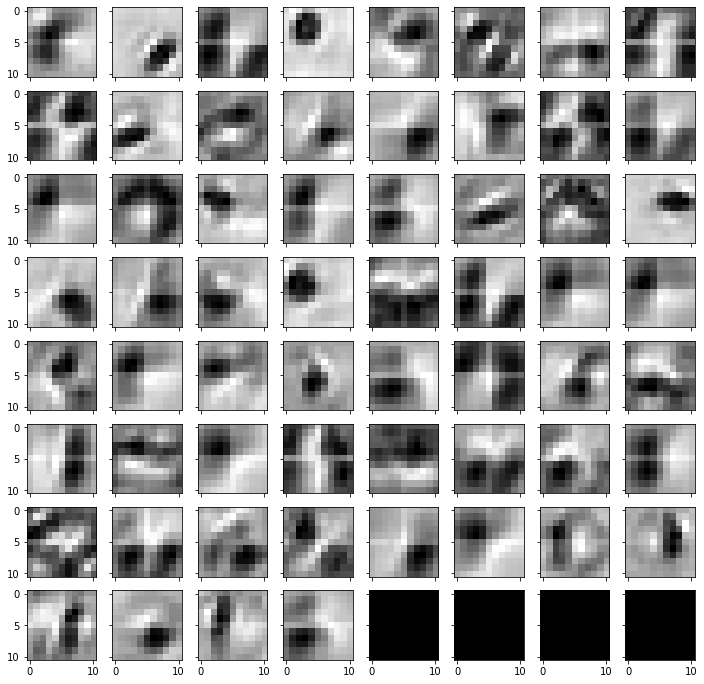


-- Channel:  29 --


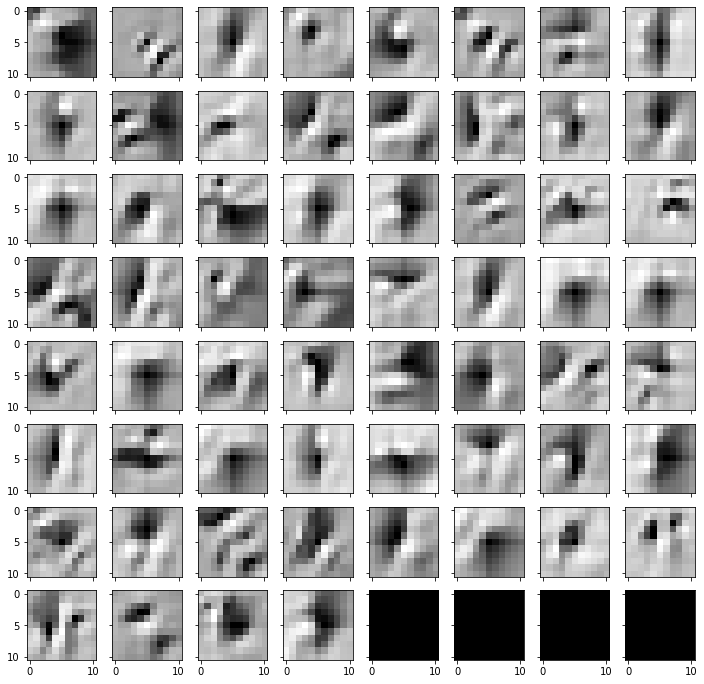


-- Channel:  30 --


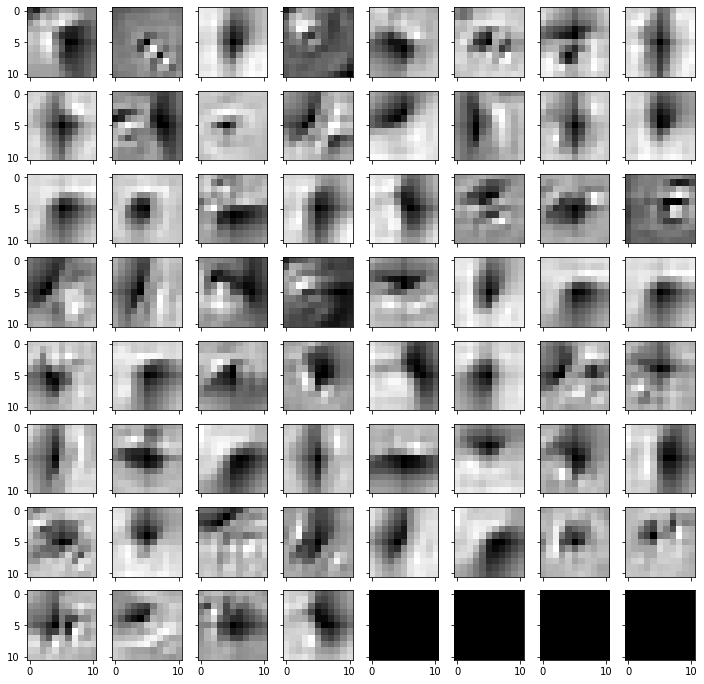

----------------------------


In [76]:
plot_filters(my_cdbn.number_layer)

### Activation maps

For the first layer, I plot the activation maps for the first 32 data samples, so that I can see the effect that each filters has on the images. These should be the (first) "hidden layer".

In [77]:
def _plot_layer_activation_maps(activation_maps):
  num_subplots = 32
  num_filters = 30
  n_cols = 8
  n_rows = 4
  
  for k in range(num_filters):
    print("\n-- Filter: ",k+1,"--")
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(12, 12))
    for i in range(n_cols*n_rows):
      col = i % n_cols
      row = i // n_cols
      if i >= num_subplots:
        axes[row, col].imshow(np.zeros((activation_maps.shape[3],activation_maps.shape[3])), cmap=plt.cm.gray)
      else:
        axes[row, col].imshow(activation_maps[i, :, :, k], cmap=plt.cm.gray)  # here we select the weights we want to plot
    plt.show()


-- Filter:  1 --


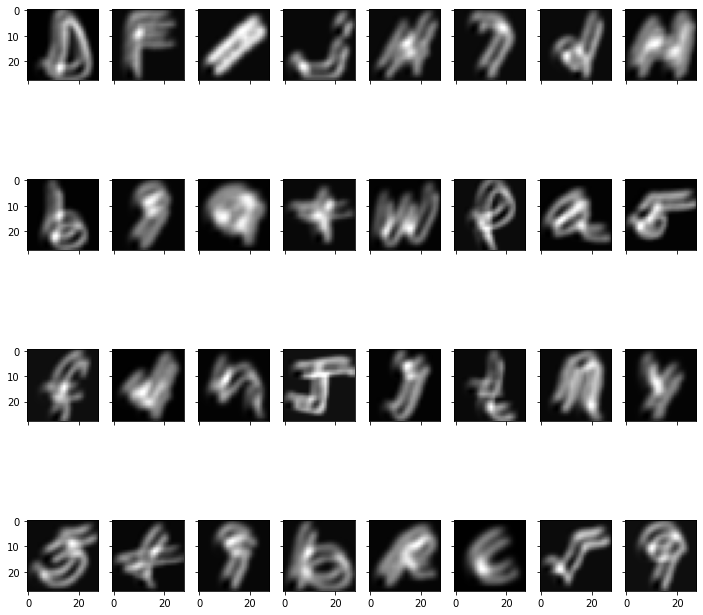


-- Filter:  2 --


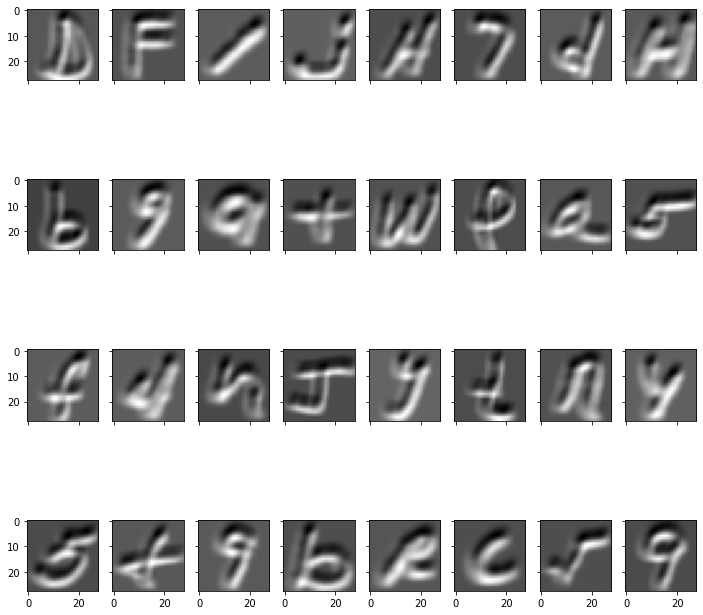


-- Filter:  3 --


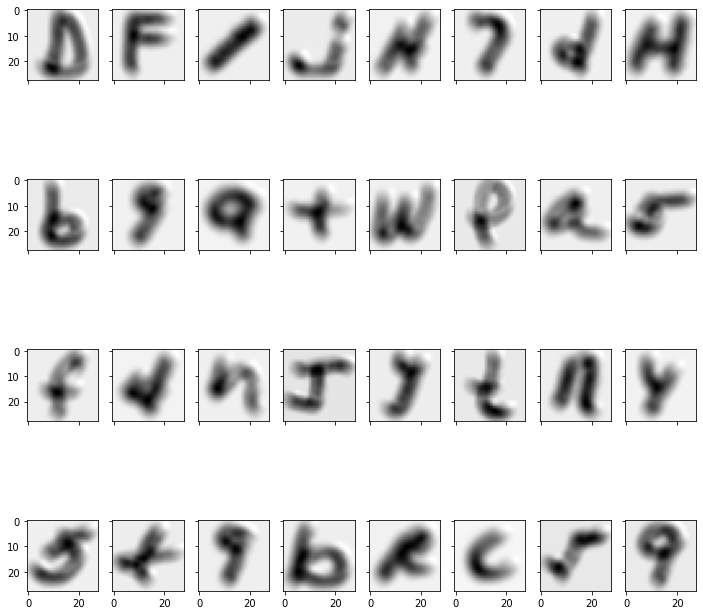


-- Filter:  4 --


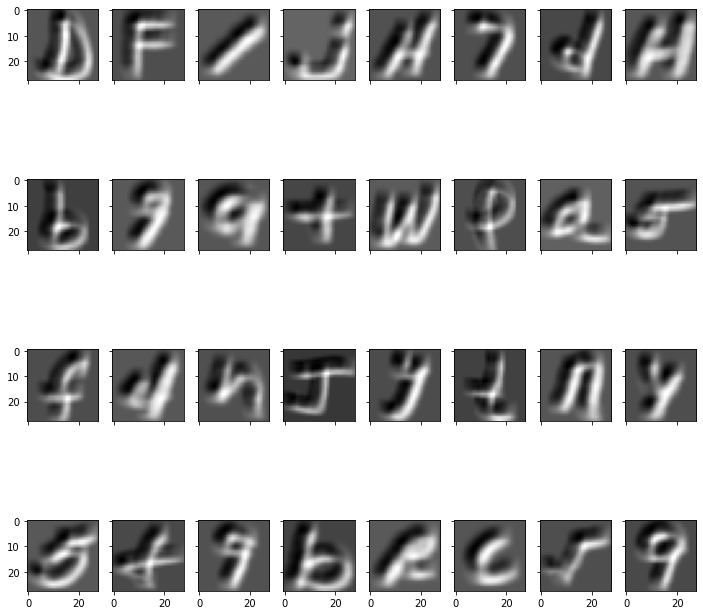


-- Filter:  5 --


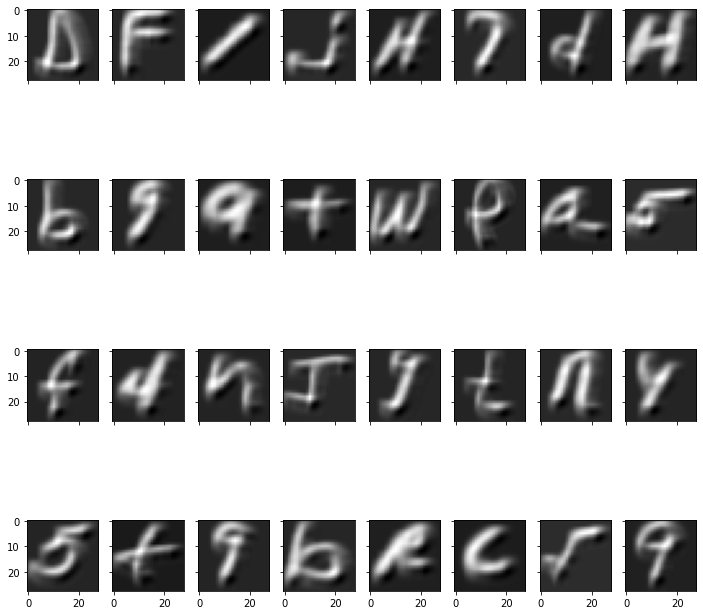


-- Filter:  6 --


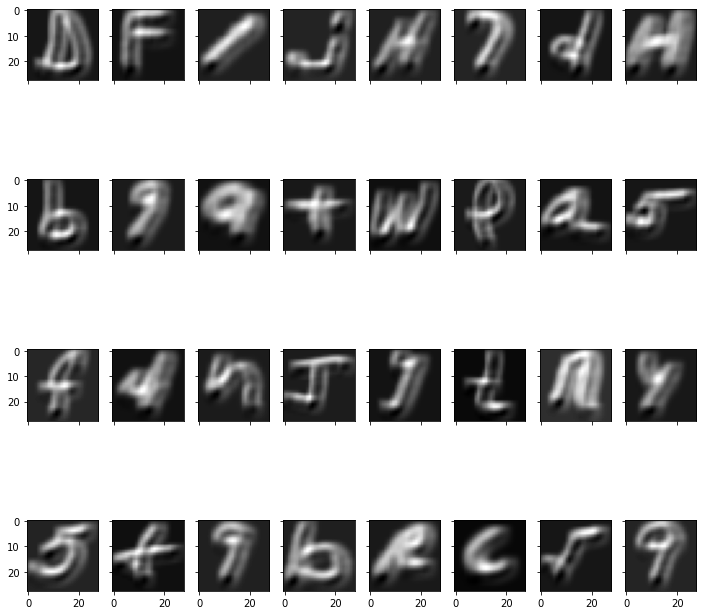


-- Filter:  7 --


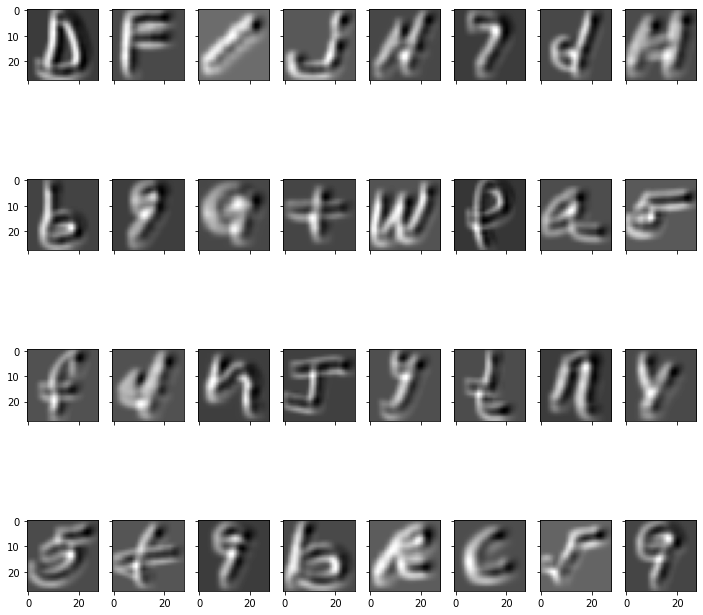


-- Filter:  8 --


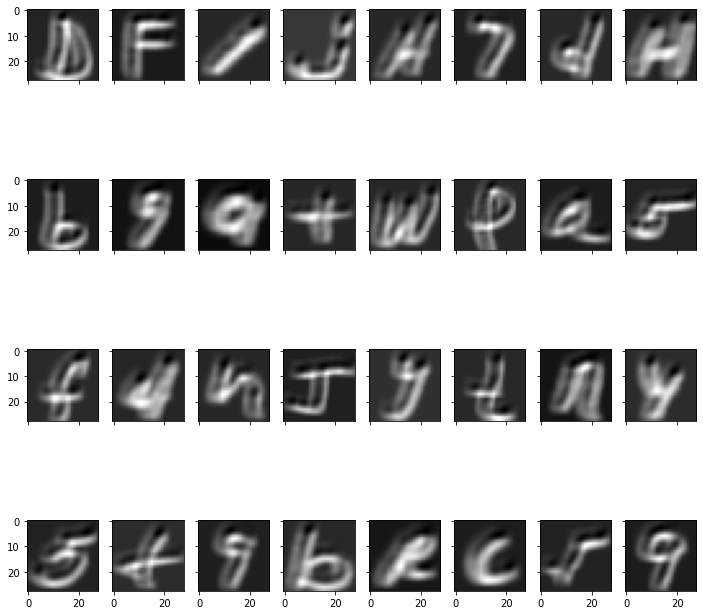


-- Filter:  9 --


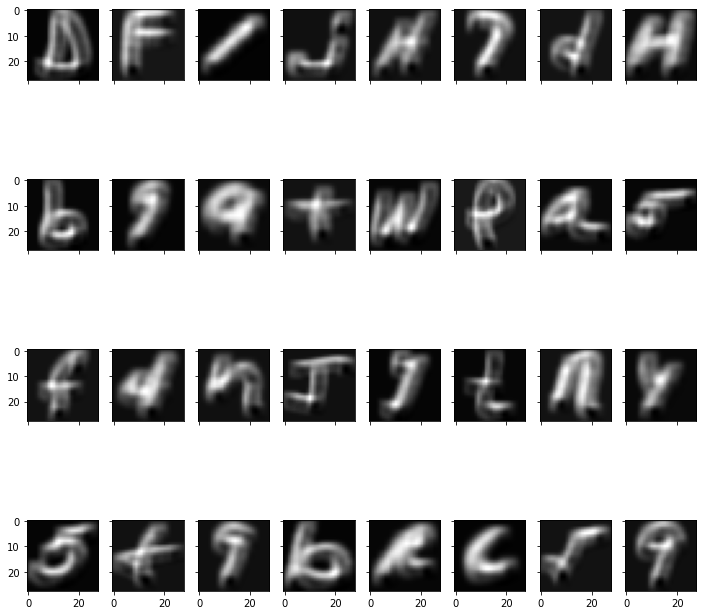


-- Filter:  10 --


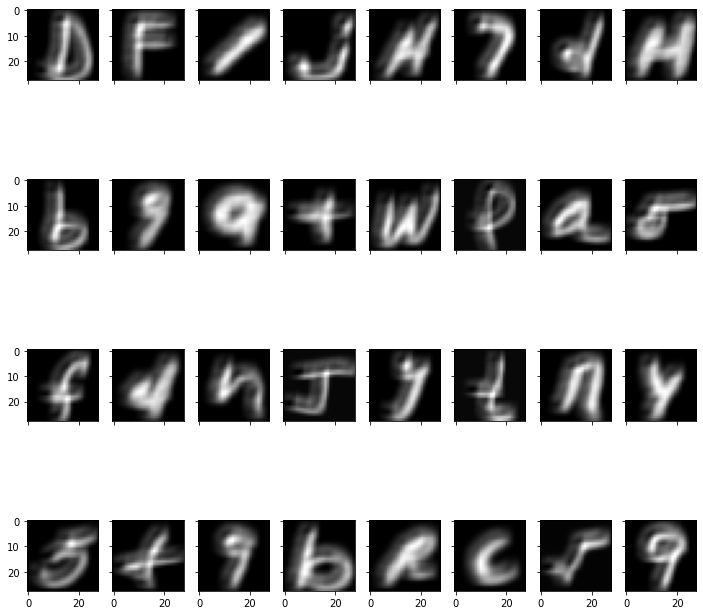


-- Filter:  11 --


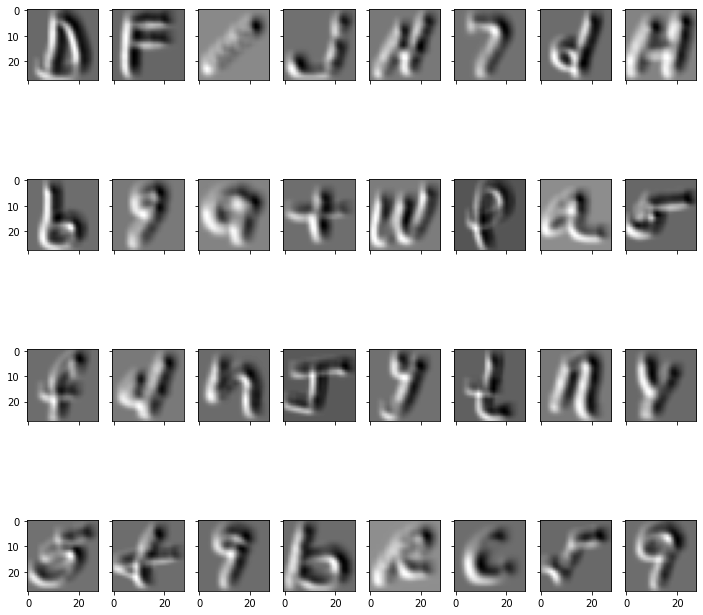


-- Filter:  12 --


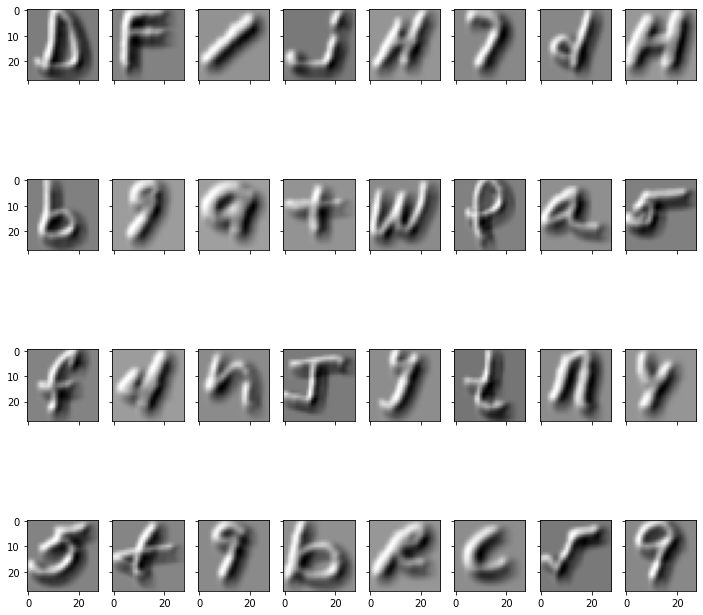


-- Filter:  13 --


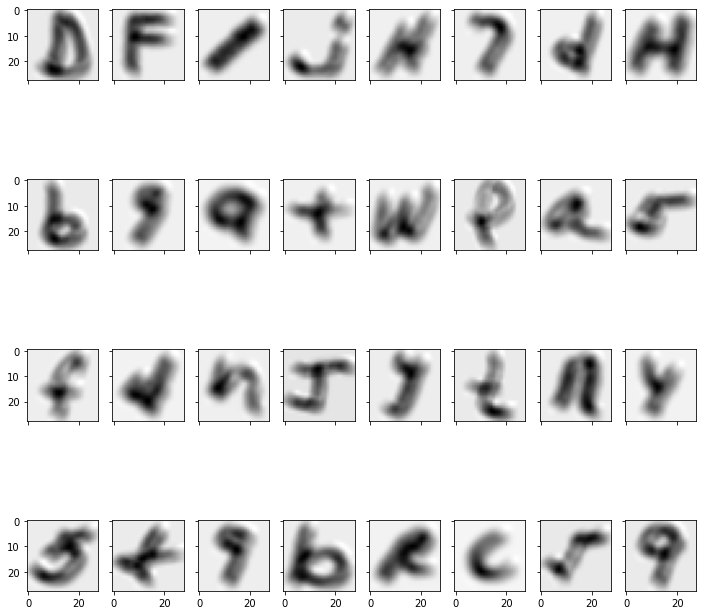


-- Filter:  14 --


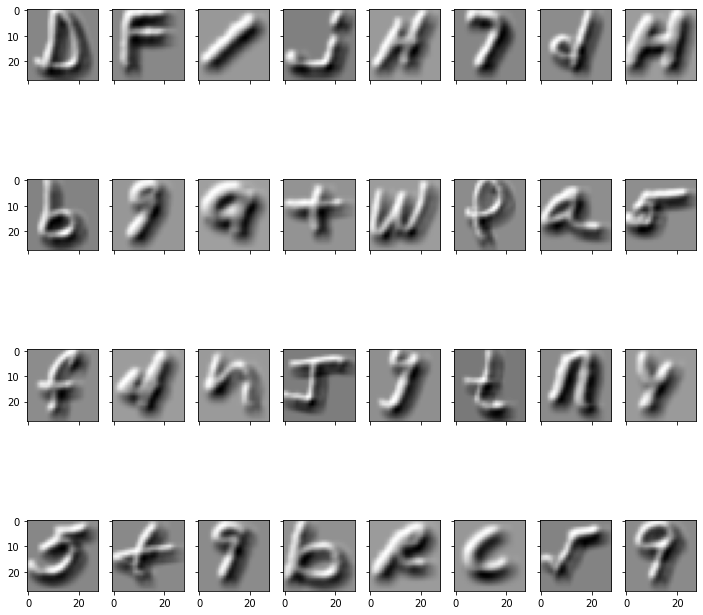


-- Filter:  15 --


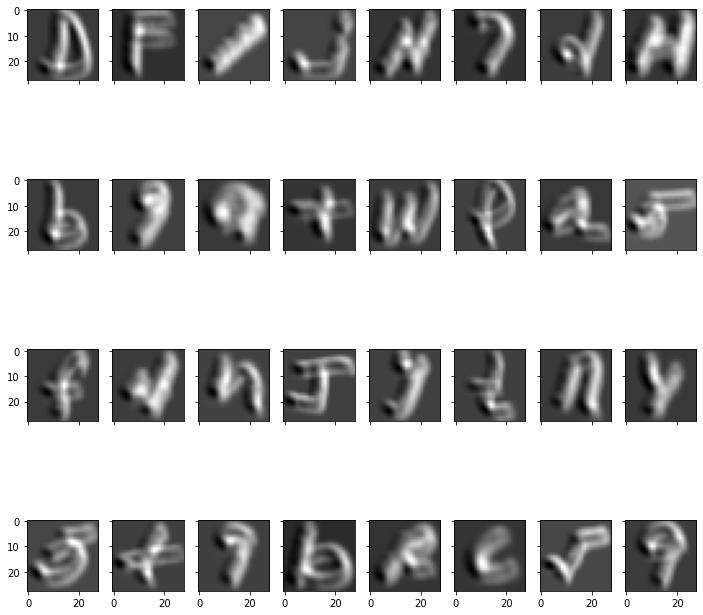


-- Filter:  16 --


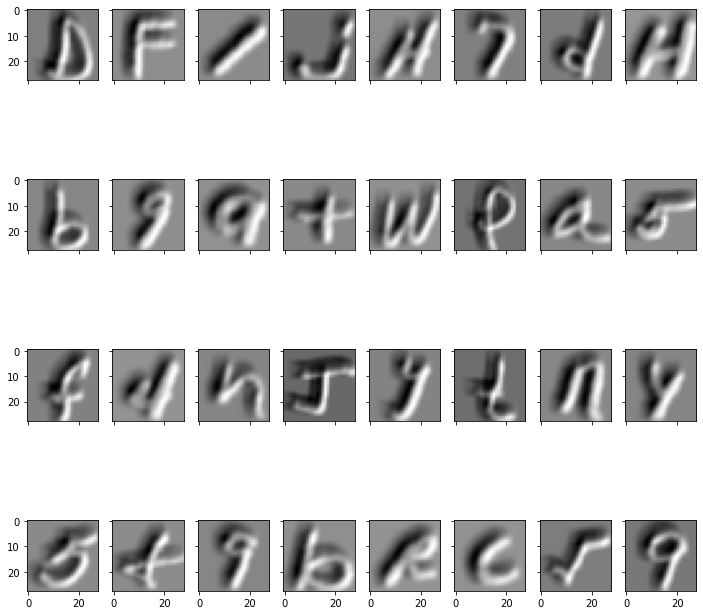


-- Filter:  17 --


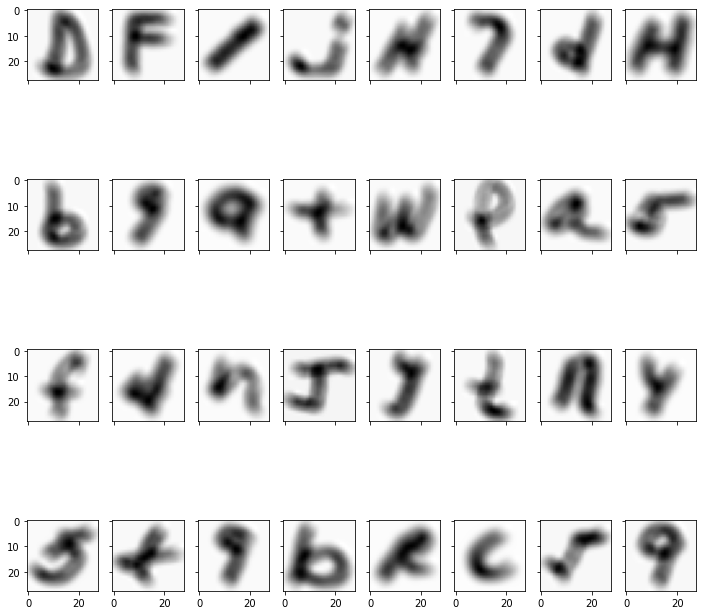


-- Filter:  18 --


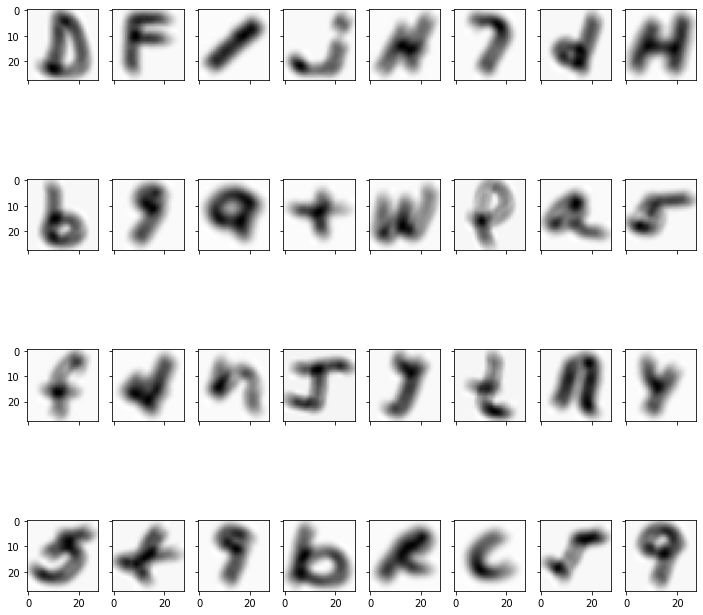


-- Filter:  19 --


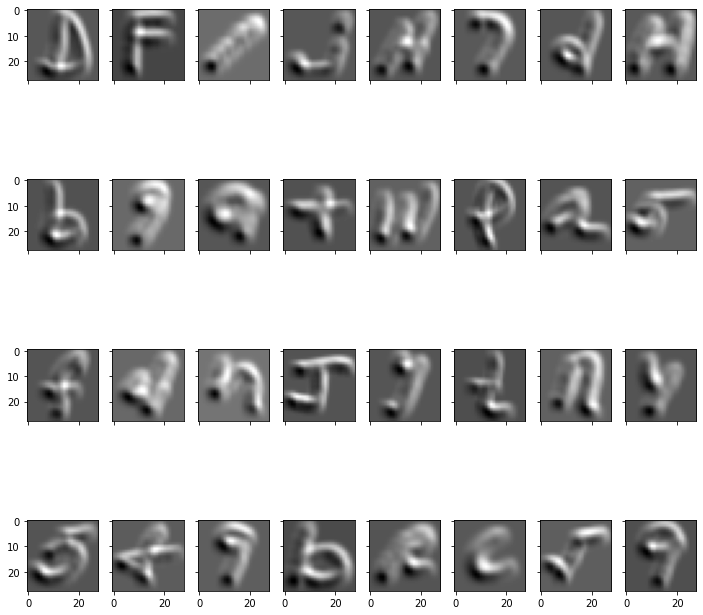


-- Filter:  20 --


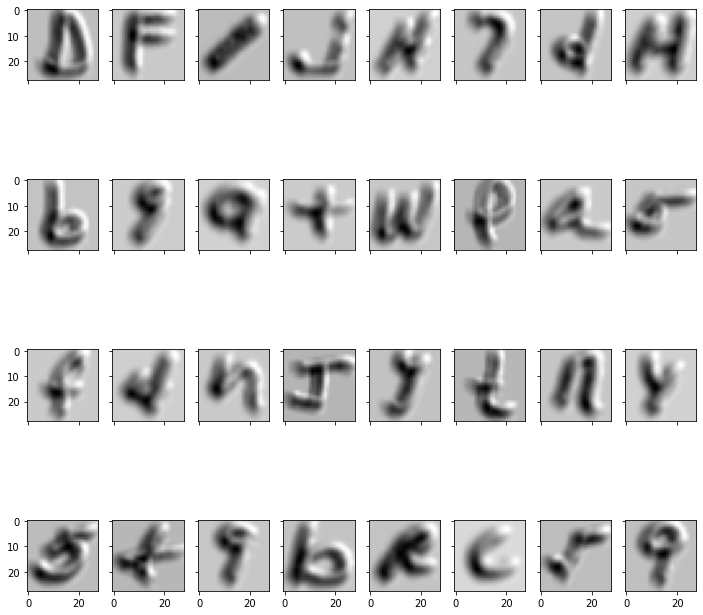


-- Filter:  21 --


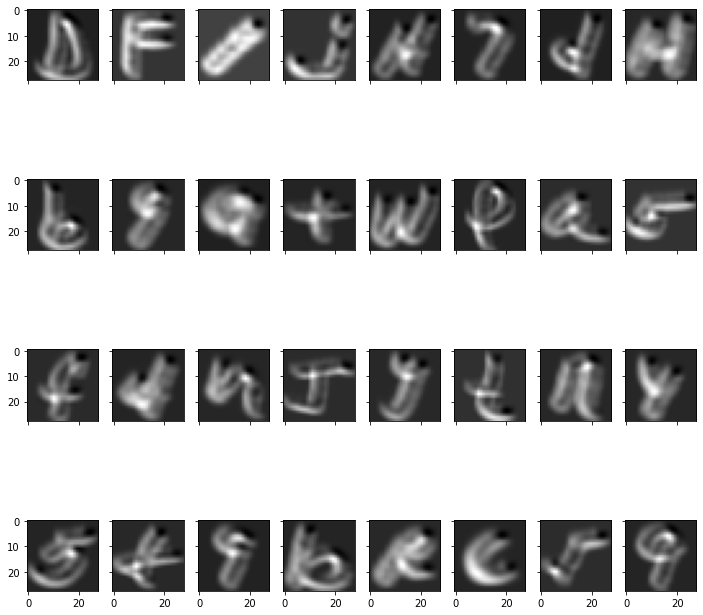


-- Filter:  22 --


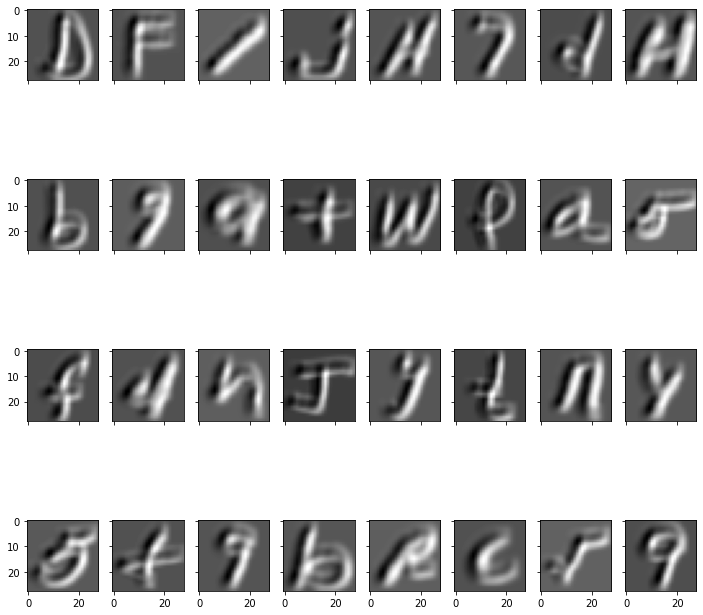


-- Filter:  23 --


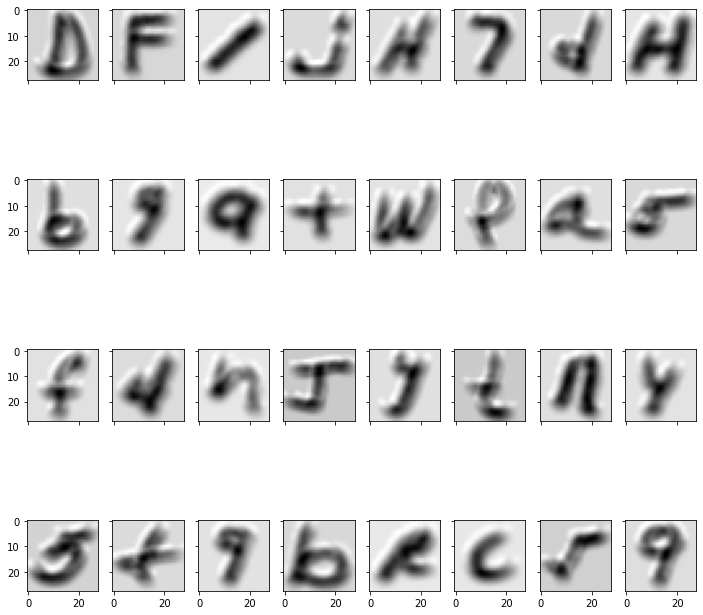


-- Filter:  24 --


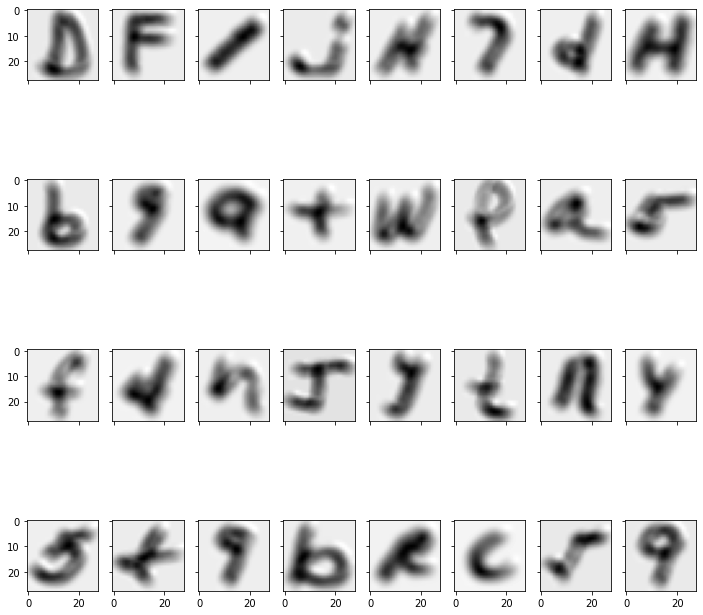


-- Filter:  25 --


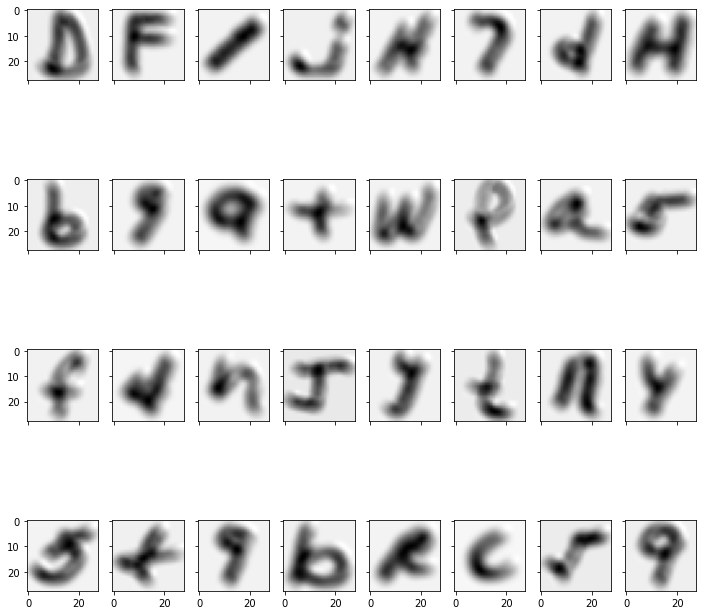


-- Filter:  26 --


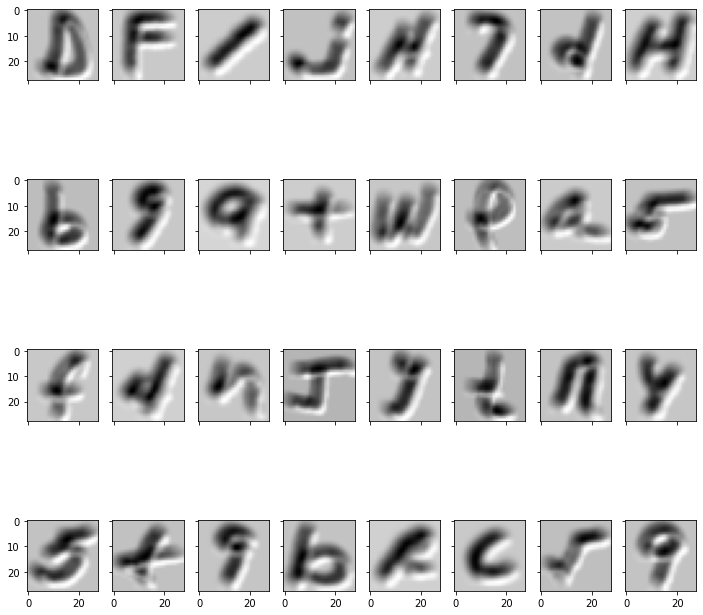


-- Filter:  27 --


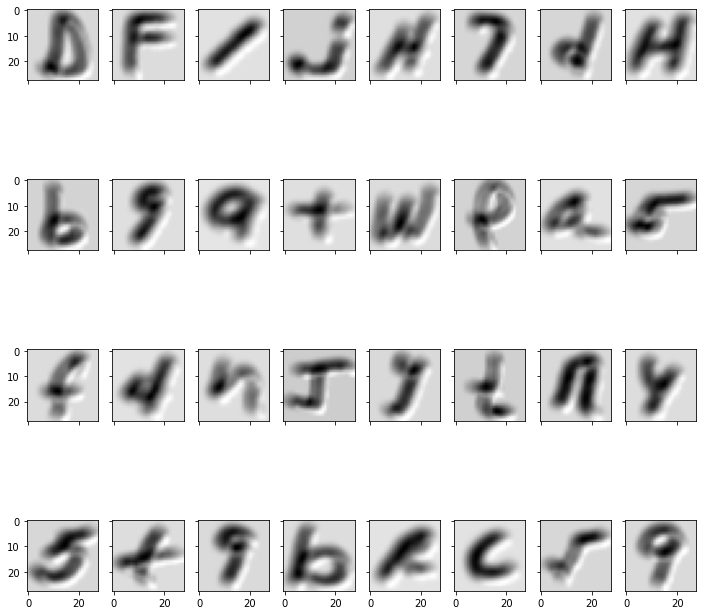


-- Filter:  28 --


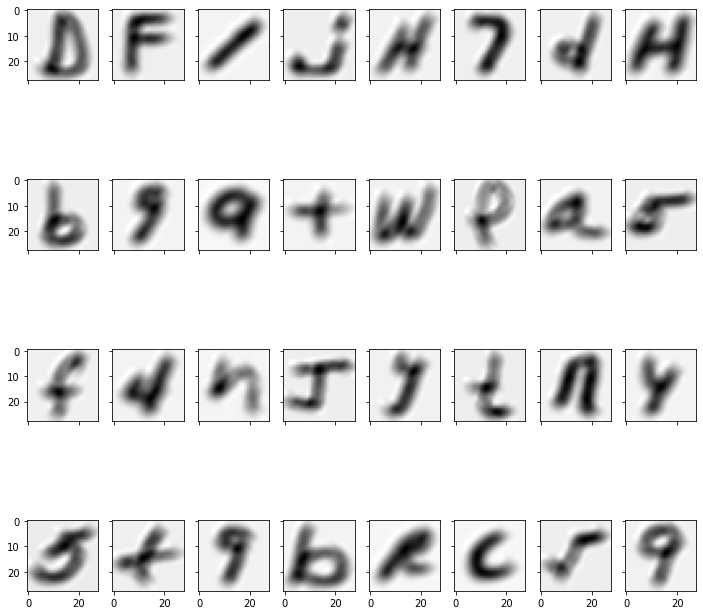


-- Filter:  29 --


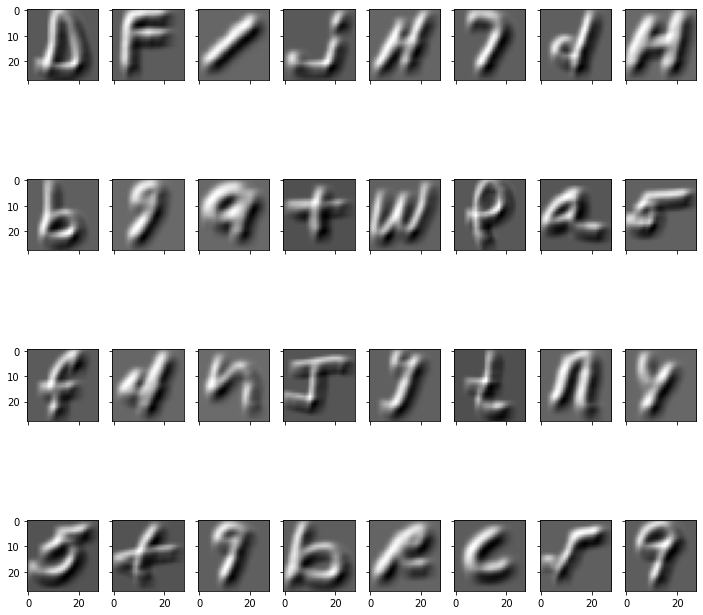


-- Filter:  30 --


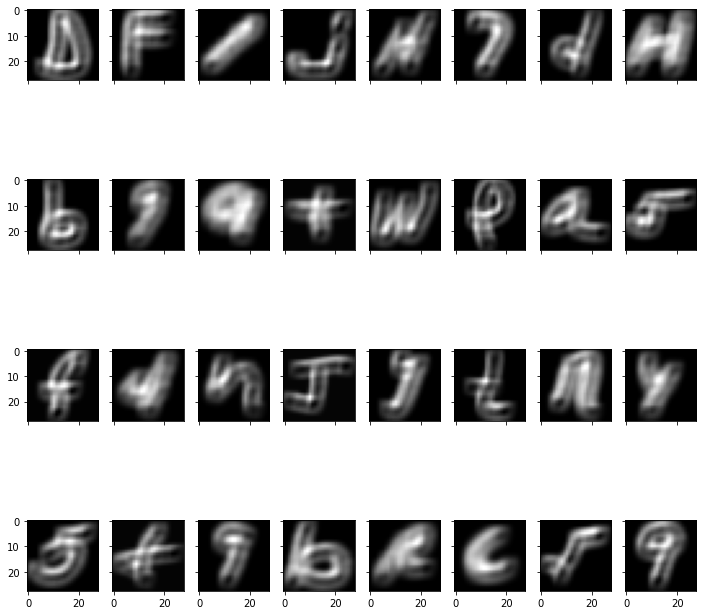

In [79]:
kernels = my_cdbn.layer_name_to_object['layer_1'].kernels
kernels = kernels.eval(session=sess)

data = np.reshape(supervised_training_images,(supervised_training_images.shape[0],supervised_training_images.shape[1],supervised_training_images.shape[2],1))

activation_maps = tf.nn.conv2d(input=data[:32, :, :], filters=kernels, strides=[1, 1, 1, 1], padding='SAME')

with tf.Session() as sess1:
   activation_maps = sess1.run(activation_maps)

_plot_layer_activation_maps(activation_maps)
